In [1]:
#import nd2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure, img_as_float
import os
from PIL import Image
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from tifffile import imread
import glob
import cv2
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.transforms import Bbox

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [3]:

def plot_channels(u):

    # Make a wider figure so we can fit in subplots
    plt.figure(figsize=(18, 15))

    # Show each of the three channels
    n_channels = len(u)

    for ii in range(n_channels):

        # Subplot indices start at 1
        plt.subplot(2, int(n_channels/2), ii+1)
	    
        # Array indices start at 0
        u_channel = u[ii]
        plt.imshow(u_channel)
        plt.title(f'Channel {ii}')
        plt.axis(False)

    plt.show()

def colorize(u, color, clip_percentile=0.1):
    """
    Helper function to create an RGB image from a single-channel image using a 
    specific color.
    """
    # Check that we do just have a 2D image
    if u.ndim > 2 and u.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')
        
    # Rescale the image according to how we want to display it
    u_scaled = u.astype(np.float32) - np.percentile(u, clip_percentile)
    u_scaled = u_scaled / np.percentile(u_scaled, 100 - clip_percentile)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    # Need to make sure we have a channels dimension for the multiplication to work
    u_scaled = np.atleast_3d(u_scaled)
    
    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return u_scaled * color
    
def imadjust(x,a,b,c,d,gamma=1):
    # Similar to imadjust in MATLAB.
    # Converts an image range from [a,b] to [c,d].
    # The Equation of a line can be used for this transformation:
    #   y=((d-c)/(b-a))*(x-a)+c
    # However, it is better to use a more generalized equation:
    #   y=((x-a)/(b-a))^gamma*(d-c)+c
    # If gamma is equal to 1, then the line equation is used.
    # When gamma is not equal to 1, then the transformation is not linear.

    y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
    return y


def rescale_by_percent_and_cut_off(u,min_percent= 0,max_percent= 100,min_cut=0,max_cut=0):
    
    if min_cut == 0 and min_cut == 0:
        min_cut = u.min()
        max_cut = u.max()

    
    u[u<=min_cut] = 0  # Subtract the minimum
    u[u>max_cut] = max_cut # Subtract the minimum
    
    u_scaled = u.astype(np.float32) - np.percentile(u, min_percent)
    u_scaled = u_scaled / np.percentile(u_scaled, max_percent)
    u_scaled = np.clip(u_scaled, 0, 1)
    
    
#     u_divided = u / max_cut  # Divide by new max
    u_inf = np.iinfo(u.dtype)
    u_multiplied = u_scaled * (2**u_inf.bits) # Multiply by dtype max
    
    u_final = u_scaled#exposure.rescale_intensity(u_rescaled, in_range=tuple(percentiles))
    return u_multiplied

def crop_im(u,y1,y2,x1,x2):

    n_channels = len(u)

    u_crop= (u[0][y1:y2,x1:x2],)

    if n_channels > 1:
        for i in range(1,n_channels):
                u_crop = u_crop + (u[i][y1:y2,x1:x2],)

    u_crop = np.stack(u_crop)

    return u_crop


def scalebar(ax,microns,Image_pixel_size):

    scalebar = AnchoredSizeBar(ax.transData,
                               microns/Image_pixel_size, str(microns) + 'um', 'lower right',
                               pad=0.1,
                               color='k',
                               frameon=False,
                               size_vertical=1,
                          bbox_to_anchor=Bbox.from_bounds(0, 0, 1, 1),
                          bbox_transform=ax.figure.transFigure)

    ax.add_artist(scalebar)

def plot_and_save(im_c_c,path_to_save,microns,Image_pixel_size,fig_title,multi):
    fig ,ax= plt.subplots()
    fig.suptitle(fig_title)
    if multi == 1:
        plt.imshow(im_c_c)
    else:
        plt.imshow(im_c_c, cmap='gray')
        
    plt.axis(False)
    scalebar(ax,microns,Image_pixel_size)
    plt.show()
    fig.savefig( path_to_save, dpi=1200,format = 'pdf')


In [42]:
# Scale bar

microns = 100
Image_pixel_size = 6.5
objective = 20
Image_pixel_size = Image_pixel_size * 2 / (objective * 1 * 1)
Image_pixel_size

0.65

In [105]:
paths_im = '/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/Characterize/RAR023/Day10/Croped_colonies/Well_1/Cropped_colony_4_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well01_ChannelA647,GFP,DAPI_Seq0000_Stitched.tif'
paths_im = '/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/Characterize/RAR023/Day10/Croped_colonies/Well_8/Cropped_colony_3_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well08_ChannelA647,GFP,DAPI_Seq0004_Stitched.tif'

paths_im = '/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/Characterize/RAR023/Day10/Croped_colonies/Well_9/Cropped_colony_7_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well09_ChannelA647,GFP,DAPI_Seq0008_Stitched.tif'

#paths_im ='/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/Characterize/RAR023/Day10/Croped_colonies/Well_4/Cropped_colony_7_binary_20210331_184910_976__Plate20210331_STR_colonies_Phalloidin_IF_Ki67_day10_Well04_ChannelA647,GFP,DAPI_Seq0003_Stitched.tif'
my_array =  imread(paths_im)

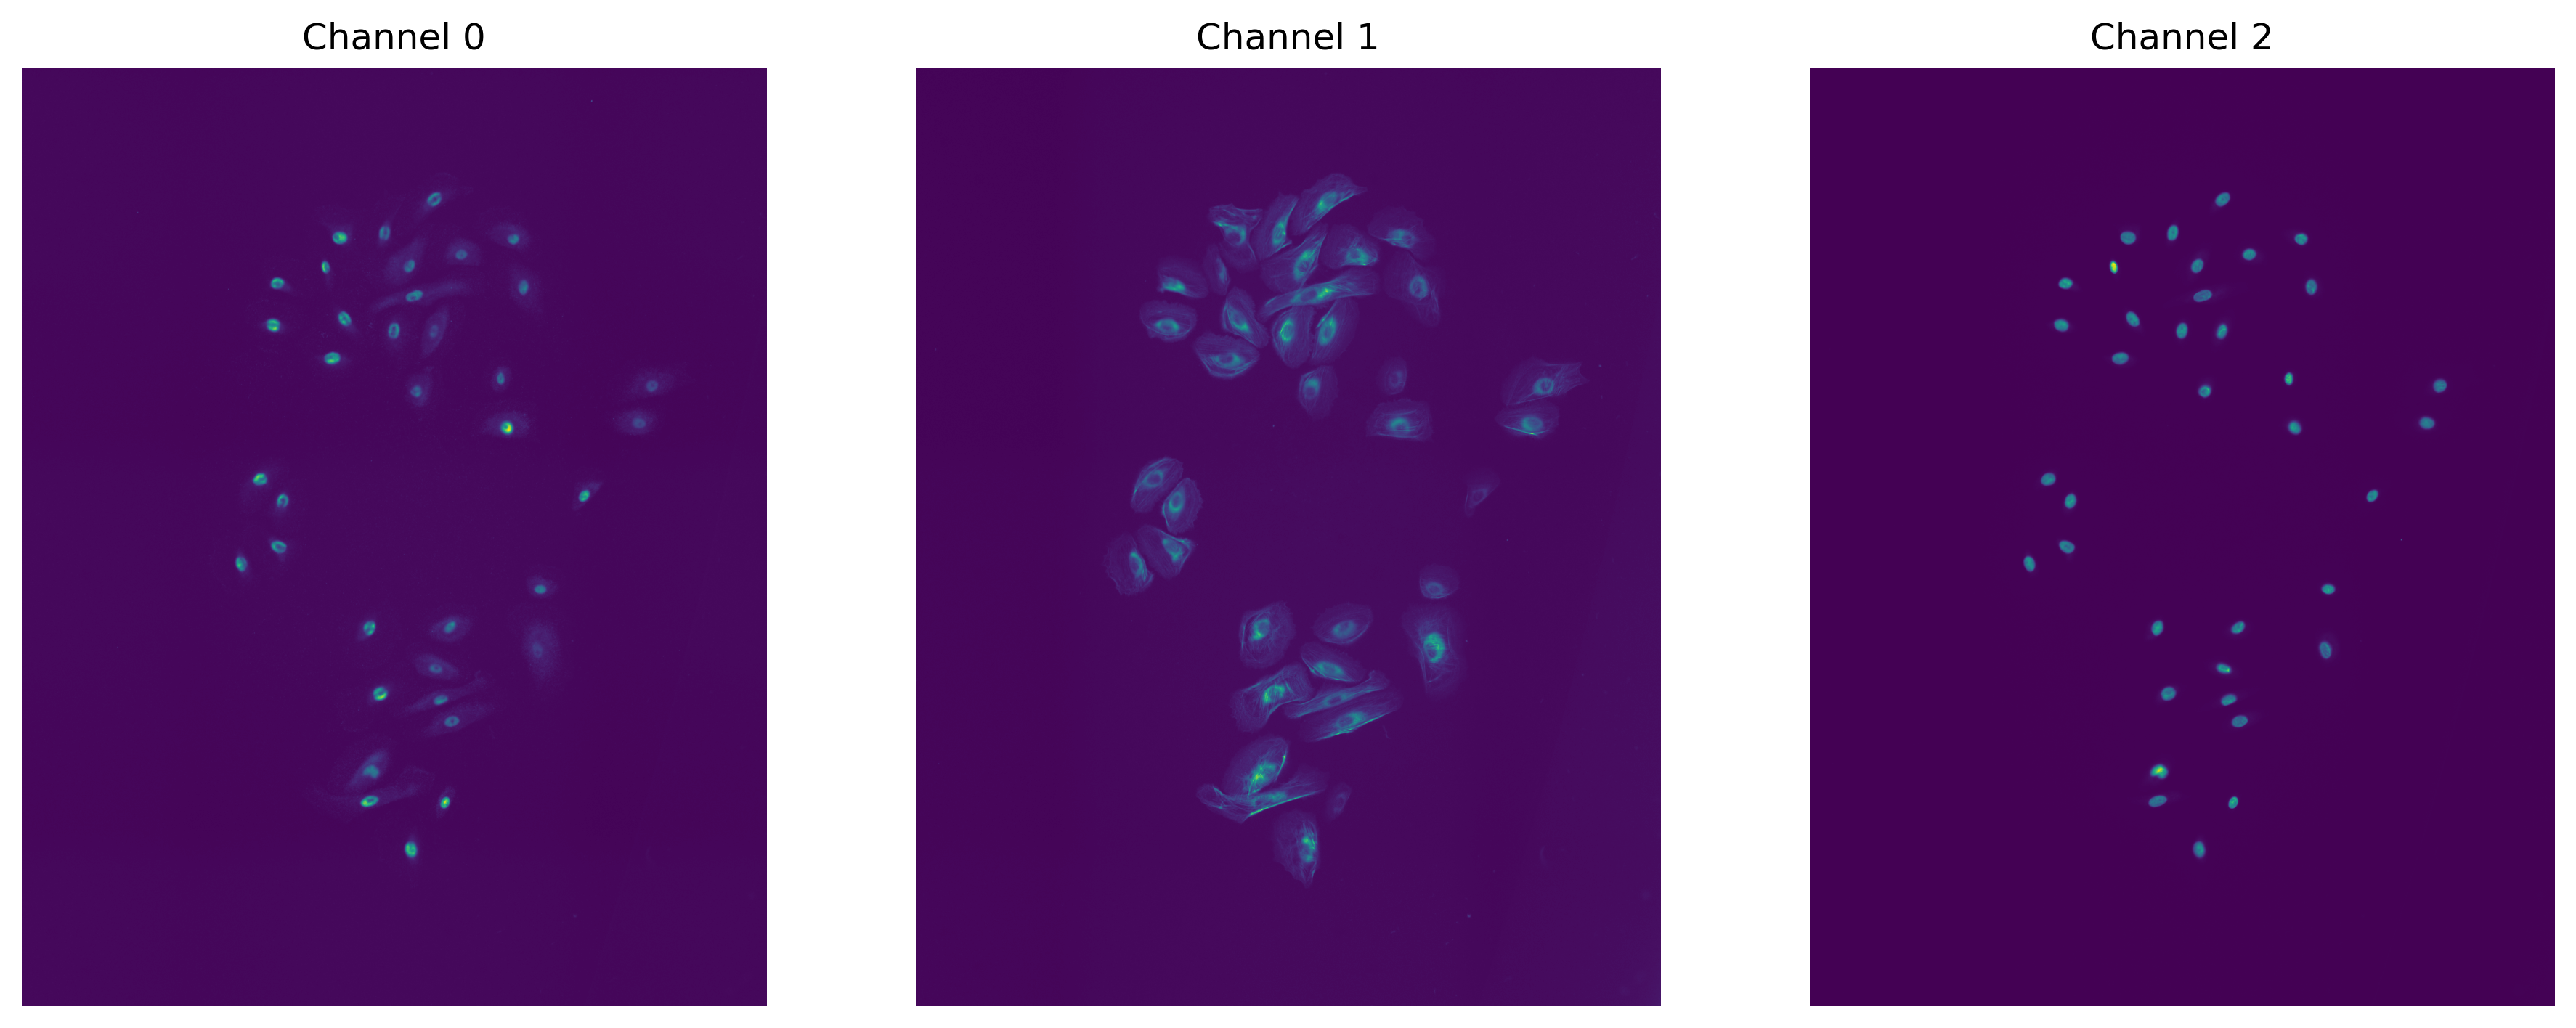

In [106]:
# Make a wider figure so we can fit in subplots
plt.figure(figsize=(15, 6))

im = my_array

# Show each of the three channels
n_channels = len(im)
for ii in range(n_channels):
    
    # Subplot indices start at 1
    plt.subplot(1, n_channels, ii+1)
    
    # Array indices start at 0
    im_channel = im[ii]
    plt.imshow(im_channel)
    plt.title(f'Channel {ii}')
    plt.axis(False)

plt.show()

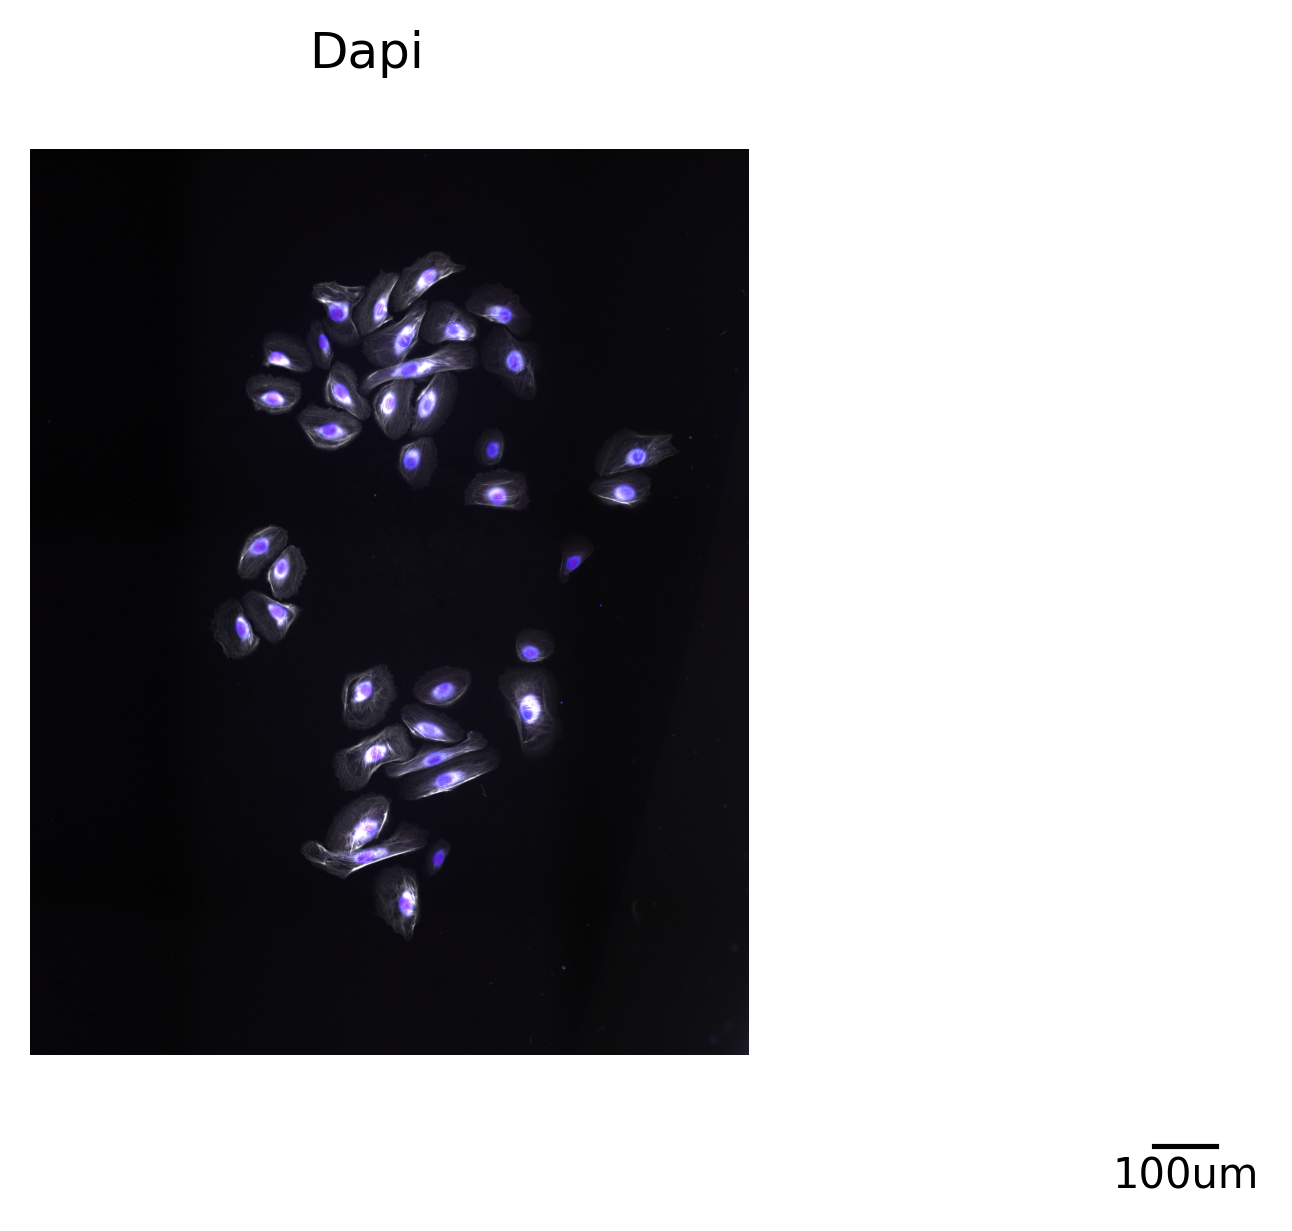

In [154]:
# large Dapi
im_numb = 2
im = imread(paths_im)

# Convert to numpy array
# npimg = np.array(im,dtype=np.float64)
# npimg[:,:,0]/=65535
# npimg[:,:,1]/=65535
# npimg[:,:,2]/=65535

# im = npimg

im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 10,max_percent= 99,min_cut=0,max_cut=1000)  #
im_dapi = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_blue = colorize(im_dapi, (0, 0, 1))/1.5


im_numb = 1


im_c_c= rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_FN1 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)

im_numb = 0

# im_o = im[im_numb]
# mean_o = np.mean(im_o[0:200,0:200])
# im_o[0:200,0:200] = 65535
im_c_c = rescale_by_percent_and_cut_off(im[im_numb],min_percent= 0,max_percent= 100,min_cut=0,max_cut=0)  #
im_KI67 = gamma_high = exposure.adjust_gamma(im_c_c, gamma=1)
mean_o

im_white  = colorize(im_FN1 , (1, 1, 1))
im_red  = colorize(im_KI67 , (1, 0, 0))
im_composite = np.clip(im_blue +im_white + im_red*np.max(im[im_numb])/65535, 0, 1)

plot_and_save(im_composite ,path_to_save,microns,Image_pixel_size,fig_title,1)



In [151]:
np.max(im_o)

#im_o = im[im_numb]
print(np.max(im_o),im.dtype)
np.mean(im_o[0:200,0:200])

65535 uint16


65535.0

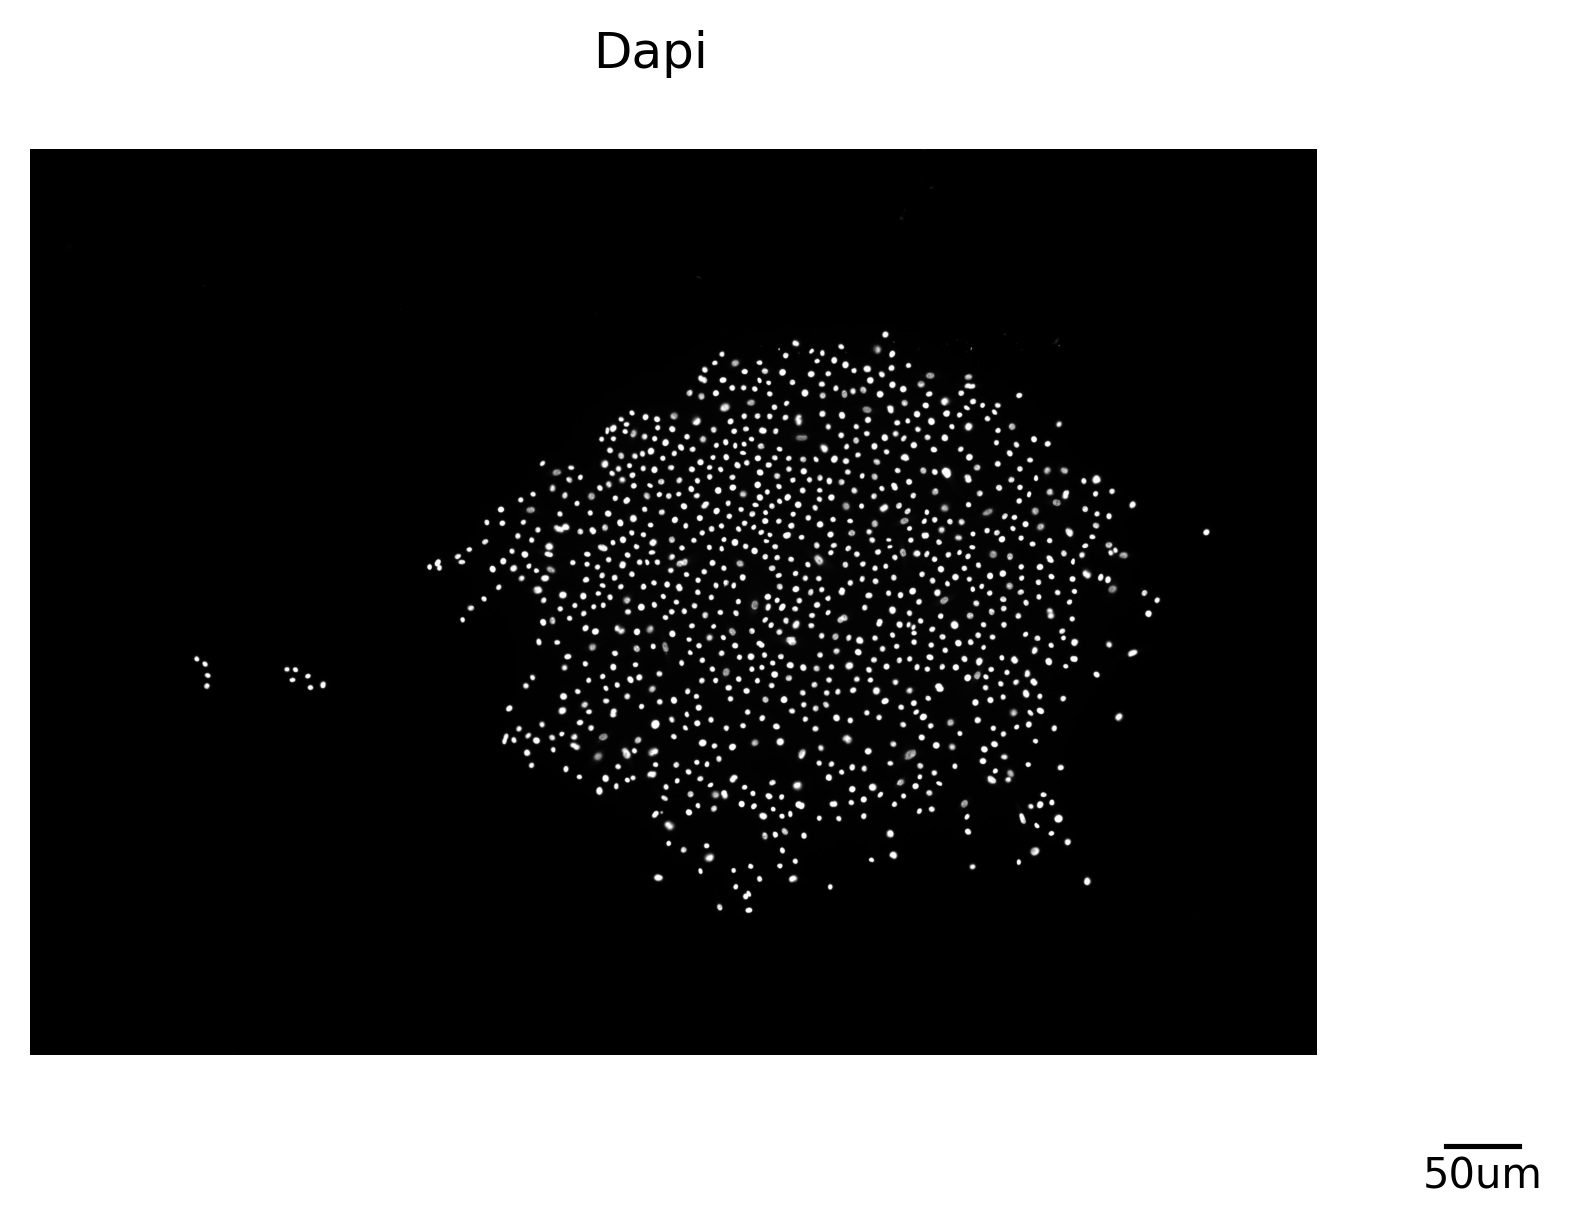

In [16]:


path_to_save = "/Volumes/GoogleDrive/My Drive/Hueros_Shared/Paper/Data/Characterize/KI67_FN1/day10_w3_c4.pdf"
fig_title = "Dapi"
plot_and_save(im_c_c,path_to_save,microns,Image_pixel_size,fig_title,0)

